# Занятие 6. Обучение моделей
До сих пор мы трактовали модели машинного обучения и их алгоритмы обучения как чёрные ящики. Если вы прорабатывали упражнения из прошлого занятия, вероятно, вы были удивлены, сколько смогли сделать, ничего не зная о "внутренней кухне". Вы усовершенствовали классификатор изображений с цифрами, смогли построить классификатор людей с паталогиями и, может быть, даже смогли построить классификатор спама, не располагая фактическими сведениями о том, как это всё функционирует. Действительно, во мноих ситуациях даже не нужно знать детали реализации.

Тем не менее, хорошее понимание того, каким образом всё работает, может помочь быстро нацелиться на подходящую модель, использовать правильный алгоритм обучения и выбрать оптимальный набор гиперпараметров для имеющейся задачи. Понимание "внутренней кухни" также будет содействовать более эффективному устранению проблем и анализу ошибок. Наконец, большинство тем, изложенных в этом ноутбуке, будут важны для освоения, построения и обучения нейронных сетей.

Начнём с исследования <b>линейной регрессионной модели</b> -- простейшей доступной модели. Мы обсудим два очень разных способа её обучения:
<ul>
    <li>Применение прямого уравнения в аналитическом виде, непосредственно вычисляющего параметры модели, которые лучше всего подгоняют модели к обучающему набору;</li>
    <li>Использование подхода итеративной оптимизации, называемой <i>градиентным спуском</i>, который постепенно корректирует параметры модели, чтобы довести до минимума значение функции издержек на обучающем наборе, в итоге сходясь к тому же набору параметров, что и в первом способе.</li>
</ul>

Затем взглянем на <i>полиномиальную регрессию</i> -- более сложную модель, которая может подгоняться к нелинейным наборам данных. 

В заключение мы рассмотрим ещё две модели, широко применяемые в задачах классификации: <i>логистическую регрессию</i> и <i>многопеременную логистическую регрессию</i>.

## Задача регрессии. Линейная регрессия
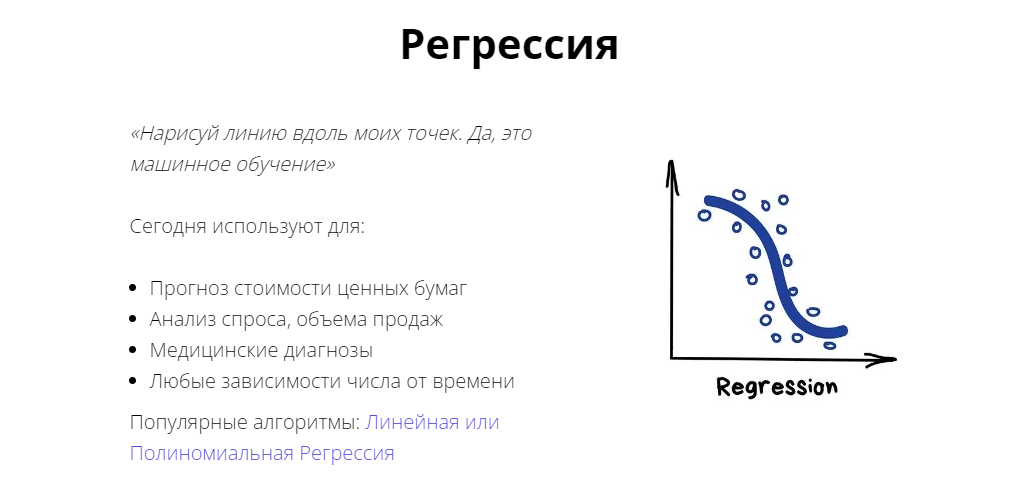

Регрессия — та же классификация, только вместо категории мы предсказываем число. Стоимость автомобиля по его пробегу, количество пробок по времени суток, объем спроса на товар от роста компании и.т.д. На регрессию идеально ложатся любые задачи, где есть зависимость от времени.

Регрессию очень любят финансисты и аналитики, она встроена даже в Excel. Внутри всё работает, опять же, банально: машина тупо пытается нарисовать линию, которая в среднем отражает зависимость. Правда, в отличии от человека с фломастером и вайтбордом, делает она это математически точно — считая среднее расстояние до каждой точки и пытаясь всем угодить.

Предположим, что вас интересует, делают ли деньги людей счастливыми. 
Вы загружаете данные “Индекс лучшей жизни” из веб-сайта Организации экономического сотрудничества и развития (ОЭСР), а также статистические данные по валовому внутреннему продукту (ВВП) на душу населения из веб-сайта Международного валютного фонда (МВФ). Затем вы соединяете таблицы и выполняете сортировку по ВВП на душу населения.

In [13]:
import pandas as pd 
import numpy as np

# загрузить данные
oecd_bli = pd.read_csv("data/oecd_bli_2015.csv",  thousands=',')  # данные об удовлетворённости жизнью
gdp_per_capita = pd.read_csv("data/gdp_per_capita.csv", thousands=',',
                             delimiter='\t', encoding='latin-1', na_values="n/a") # данные о ВВП на душу населения за 2015 год

oecd_bli.head(5)

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


In [14]:
gdp_per_capita.head(5)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


In [16]:
# подготовка данных
gdppc_col = "2015" # показатель ВВП

# удалить лишние столбцы из  gdp_per_capita
gdp_per_capita = gdp_per_capita.drop(["Subject Descriptor", "Units", "Scale",
                                     "Country/Series-specific Notes", "Estimates Start After"], axis=1)
# оставить в таблице с ВВП только данные о стране и её показателе ВВП
gdp_per_capita.columns = ["Country", gdppc_col]
# сделать столбец со значениями стран индексами 
gdp_per_capita.set_index("Country", inplace=True)
# показать таблицу
gdp_per_capita.head()

,2015
Country,
Afghanistan,599.994
Albania,3995.383
Algeria,4318.135
Angola,4100.315
Antigua and Barbuda,14414.302


In [17]:
# нужно оставить в этой таблице только значение удовлетворенности жизнью
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
# сделать сводную таблицу, где в качестве индексов будут значения стран
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

oecd_bli.head()

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2


In [19]:
# склеить две таблицы по общим индексам -- названиям стран
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                              left_index=True, right_index=True)
full_country_stats.sort_values(by=gdppc_col, inplace=True)
full_country_stats.head()

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,2015
Country,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3,8669.998
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,...,16193.0,77.0,1.0,66.0,417.0,13.89,63.0,67.0,14.4,9009.280
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,12239.894


In [22]:
# оставить только две колонки -- ВВП и индекс удовлетворенности жизнью
full_country_stats = full_country_stats[[gdppc_col, 'Life satisfaction']]
full_country_stats.head()

,2015,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9


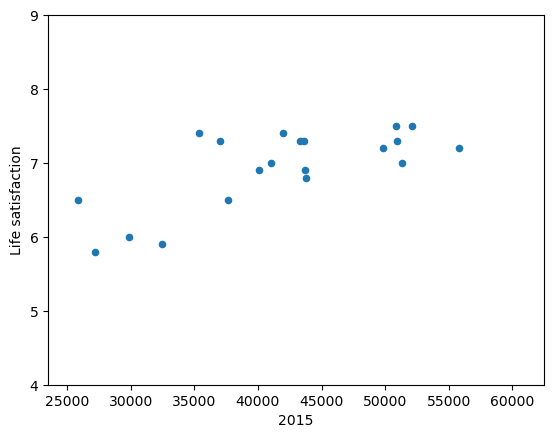

In [26]:
# Визуализировать данные
import matplotlib.pyplot as plt
full_country_stats.plot(kind='scatter', x="2015", y='Life satisfaction')
plt.axis([23_500, 62_500, 4, 9])
plt.show()

Теперь, когда данные подготовлены, можно попробовать найти с помощью машинного обучения некоторую закономерность в этом облаке точек, а после этого -- возможно, даже предсказывать новые данные. Глядя на этот график, вы делаете предположение, что удовлетворённость жизнью определяется линейно относительно ВВП на душу населения и предполагаете следующую зависимость.
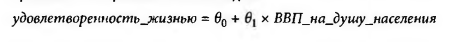

Линейная зависимость -- выбор падает на модель линейной регресси.

In [32]:
from sklearn.linear_model import LinearRegression

X = np.c_[full_country_stats["2015"]] 
y = np.c_[full_country_stats["Life satisfaction"]]

model = LinearRegression()
model.fit(X, y)

# Выработать прогноз для Кипра
X_new = [[22587]] # ВВП на душу населения Кипра
print(model.predict(X_new)) 


[[6.28653637]]


Можно посмотреть, какие коэффициенты подобрал алгоритм для этих данных.

In [38]:
t0, t1 = model.intercept_[0], model.coef_[0][0]
print(f"θ0={t0:.2f}, θ1={t1:.2e}")

θ0=5.76, θ1=2.32e-05


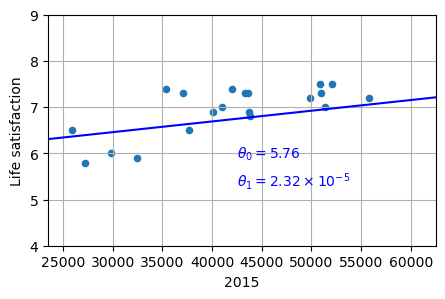

In [40]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x='2015', y='Life satisfaction')

min_life_sat = 4
max_life_sat = 9
min_gdp = 23_500
max_gdp = 62_500

X = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X, t0 + t1 * X, "b")

plt.text(max_gdp - 20_000, min_life_sat + 1.9,
         fr"$\theta_0 = {t0:.2f}$", color="b")
plt.text(max_gdp - 20_000, min_life_sat + 1.3,
         fr"$\theta_1 = {t1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])
plt.show()

Как правило, линейная модель вырабатывает прогноз, просто вычисляя взвешенную сумму входных признаков и добавляя к ней константу под названием <i>член смещения</i>, которая также называется <i>свободным членом (intercept term)</i>.

В общем виде уравнение выглядит следующим образом:

$$\hat{y} = \theta_0 + \theta_1 x_1 + ... \theta_n x_n.$$

Это ещё не самое страшное. :D
Здесь всё просто:
<ul>
    <li>$\hat{y}$ -- это значение, которое предсказывает модель;</li>
    <li>$\theta_n$ -- это значение параметра модели для n-ого признака;</li>
    <li>$x_n$ -- это значение самого n-ого признака.</li>
</ul>



Итак, у нас есть линейная регрессионная модель. Но как её обучать? <b>Обучение модели</b> -- установка её параметров так, чтобы модель была наилучшим образом подогнана к обучающему набору. Для этой цели первым делом нужна мера того, насколько хорошо (или плохо) модель подогнана к обучающим данным.

### Метрики регрессии
Первой метрикой, с которой мы познакомимся, будет MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это средняя сумма рублей, на которую мы облажались.

Второй метрикой является MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 долларов, то в ошибку войдёт 25. Если мы ошиблись на 10 долларов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

Часто для нас принципиальным является не то, на сколько единиц мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

Её нам придётся реальзовать самостоятельно. Благо, это не очень трудно. 

Последняя метрика, с которой нам нужно познакомиться, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков, о которых вы можете узнать из книг. 

### Нормальное уравнение
Для нахождения значения $\theta$, которое сводит к минимуму <b>функцию издержек</b> (метрику регрессии, которая показывает, насколько ошиблась модель), имеется решение в аналитическом виде -- иными словами, математическое уравнение, дающее результат напрямую. Оно называется <i>нормальным уравнением</i> и представлено ниже.
$$\hat{\theta} = (X^T X)^{-1} X^T y$$

Теперь мы взглянем на совершенно другие способы обучения линейной регрессионной модели, которые лучше подходят в случаях, когда имеется большое число признаков или слишком много образцов в обучающем наборе, чтобы уместиться в память.

## Градиентный спуск

Градиентный спуск представляет собой самый общий алгоритм оптимизации, способный находить оптимальные решения широкого диапазона задач. Основная идея градиентного спуска заключается в том, чтобы итеративно подстраивать параметры для доведения до минимума функции издержек.

Предположим, вы потерялись в горах в густом тумане; вы способны прощупывать только крутизну поверхности под ногами. Хорошая стратегия быстро добраться до дна долины предусматривает движение вниз по самому крутому спуску. Это в точности то, что делает градиентный спуск: он измеряет локальный градиент функции ошибок применительно к массиву параметров $\theta$ и двигается в направлении убывающего градиента. Как только градиент становится нулевым -- вы достигли минимума.

Важным параметром в градиентном спуске является размер шагов, определяемый гиперпараметром <i>скорости обучения</i> (learning rate). Если скорость обучения слишком мала, тогда алгоритму придется пройти множество итераций, что потребует длительного времени.

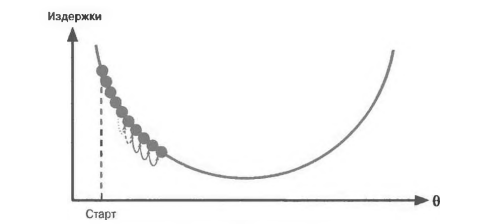

С другой стороны, если скорость обучения слишком высока, вы можете перескочить долину и оказаться на другой стороне, возможно, даже выше, чем вы находились ранее. Это способно сделать алгоритм расходящимся, что приведёт к выдаче постоянно увеличивающихся значений.

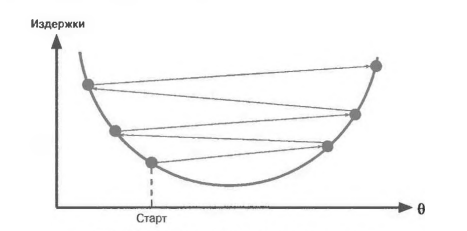

Наконец, не все функции издержек выглядят как точные правильные чаши. Могут существовать впадины, выступы, плато и самые разнообразные участки нерегулярной формы, которые затрудняют схождение в минимуме. Ниже проиллюстрированы две главные проблемы с градиентным спуском: если случайная инициализация начинает алгоритм слева, то он сойдется в точке локального минимума, который не настолько хорош, как глобальный минимум. Если алгоритм начнется справа, тогда он потратит очень долгое время на пересечение плато и в случае его слишком ранней остановки глобальный минимум никогда не будет достигнут.

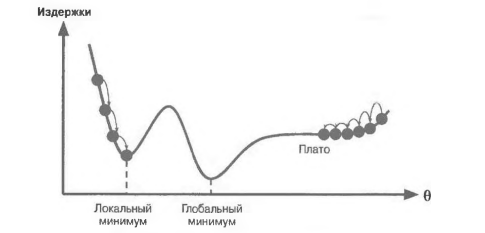

К счастью, функция издержек MSE для линейной регрессионной модели является выпуклой функцией, т.е. если выбрать любые две 
точки на кривой, то соединяющий их отрезок прямой никогда не пересекает кривую. Отсюда следует, что локальные минимумы отсутствуют, а есть только один глобальный минимум. Она также представляет собой непрерывную функцию с наклоном, который никогда не изменяется неожиданным образом. Упомянутые два факта имеют большое значение: градиентный спуск гарантированно подберется произвольно близко к глобальному минимуму (если вы подождете достаточно долго и скорость обучения не слишком высока).

## Полиномиальная регрессия 
Что, если ваши данные сложнее прямой линии? Удивительно, но вы можете применять линейную модель для подгонки к нелинейным данным. Простой способ предполагает добавление степеней каждого признака в виде новых признаков и последующее обучение линейной модели на таком расширенном наборе признаков. Этот прием называется <i>полиномиальной регрессией (Polynomial Regression)</i>.

Рассмотрим пример. Для начала сгенерируем нелинейные данные, основываясь на простом квадратном уравнении (плюс некоторый шум).

In [77]:
import numpy as np
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.6 * X**2 + X + 2 + np.random.randn(m, 1)

Безусловно, прямая линия никогда не будет подогнана под такие данные должным образом. Потому мы воспользуемся классом PolynomialFeatures из ScikitLearn, чтобы преобразовать наши обучающие данные, добавив в качестве нового признака квадрат (полином 2-й степени) каждого признака (в этм случае есть только один признак):

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.57772804])

In [19]:
X_poly[0]

array([1.57772804, 2.48922577])

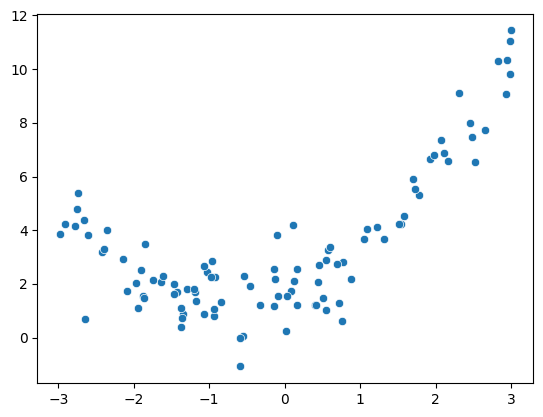

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=X_poly[:, 0], y=y.reshape(-1));

Теперь X_poly содержит первоначальный признак X плюс его квадрат. Далее вы можете подогнать модель LinearRegression к таким расширенным обучающим данным:

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.65994595]), array([[0.96522614, 0.65547936]]))

Неплохо: модель оценивает функцию как  $\hat{y} = 0.65x^{2} + 0.93x + 1.66$, когда на самом деле исходной функцией была $y = 0.6x^2 + x + 2 + гауссов\_шум$.

Обратите внимание, что при наличии множества признаков полиномиальная регрессия способна отыскать связи между признаками (то, что простая линейная регрессия делать не в состоянии). Это становится возможным благодаря тому, что класс PolynomialFeatures также добавляет все комбинации признаков вплоть до заданной степени.

Например, если есть два признака a и b, тогда класс PolynomialFeatures с degree=3 добавил бы не только признаки $a^2$, $a^3$, $b^2$, $b^3$, но и комбинации $ab$, $a^2b$, $ab^2$.

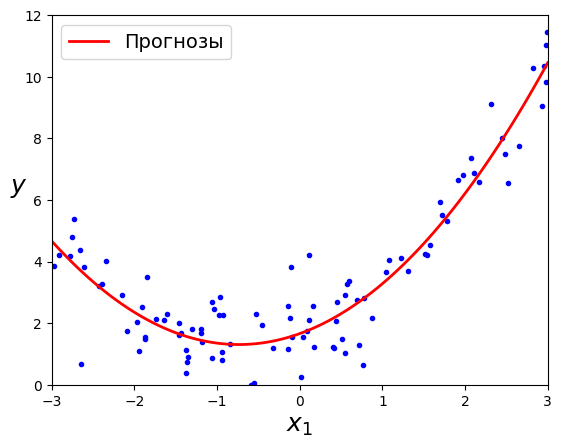

In [53]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Прогнозы")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 12])
plt.show()

## Кривые обучения
Полиномиальная регрессия высокой степени, вероятно, обеспечит гораздо лучшую подгонку к обучающим данным, чем обыкновенная линейная регрессия. Например, ниже демонстрируется применение полиномиальной модели 300-й степени к предшествующим обучающим данным, а результат сравнивается с чистой линейной моделью и квадратичной моделью (полиномиальной второй степени). Обратите внимание на то, как полиномиальная модель 300-й степени колеблется, чтобы как можно больше приблизиться к обучающим образцам.

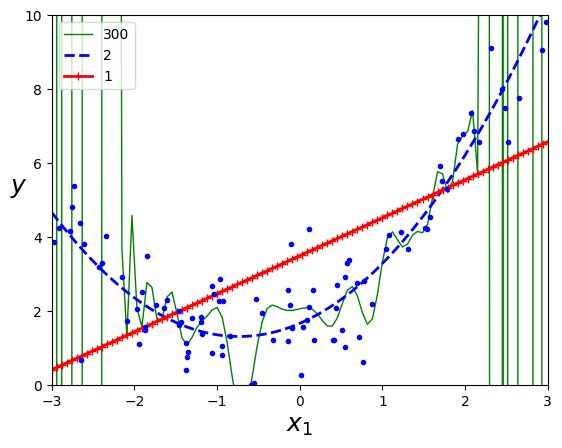

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Такая полиномиальная регрессионная модель высокой степени вызывает сильное <b>переобучение</b> обучающими данными, тогда как линейная модель -- <b>недообучение</b> на них. 

Все модели могут как переобучаться, так и недообучаться. Переобучение -- это нежелательная ситуация, когда ваша модель поглощает данные и показывает отличные результаты на тренировочном наборе, но, когда видит новые данные (проверочные данные), её качество катастрофически падает. Недообучение -- другая нежелательная ситуация, когда вашей модели не хватает данных для того, чтобы <b>обобщиться</b>. Обобщающая способность -- это способность модели экстраполировать открытые ею закономерности на новые данные, которые она ещё не видела. Модель имеет обобщающую способность только тогда, когда ошибка на тестовых данных достаточно мала или хотя бы предсказуема.

Эффективность обобщения модели можно оценивать при помощи перекрёстной проверки (кроссвалидации). Если согласно метрикам перекрестной проверки модель хорошо работает на обучающих данных, но плохо обобщается, то модель переобучена. Если модель плохо выполняется в обоих случаях, тогда она недообучена. Так выглядит один из способов сказать, что модель слишком проста или чрезмерно сложна.

Другой способ предусматривает просмотр кривых обучения: они представляют собой графики эффективности модели на обучающем наборе и проверочном наборе как функции от размера обучающего набора (или от итерации обучения). Чтобы получить такие графики, нужно просто обучить модель несколько раз на подмножествах разных размеров, взятых из обучающего набора. В следующем коде определяется функция, которая вычерчивает кривые обучения модели для установленных обучающих данных:

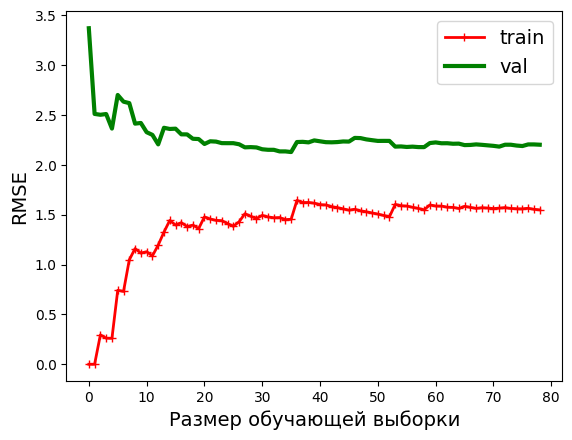

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "g-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Размер обучающей выборки", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)       
    
# посмотрим на кривые обучения линейной регрессии
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

Представленная модель, которая недообучается, заслуживает некоторых пояснений. Первым делом обратите внимание на эффективность модели в случае использования обучающих данных: когда в обучающем наборе есть только один или два образца, модель может быть в полной мере подогнана к ним, что и объясняет начало кривой с нулевой ошибки. Но по мере добавления образцов в обучающий набор идеальная подгонка модели к обучающим данным становится невозможной, как из-за того, что данные зашумлены, так и потому, что они совершенно отличаются от линейных. Следовательно, ошибка на обучающих данных двигается вверх, пока не стабилизируется, когда добавление новых образцов в обучающий набор не делает среднюю ошибку намного лучше или хуже. Теперь перейдём к просмотру эффективности модели на проверочных данных. Когда модель обучалась на незначительном количестве обучающих образцов, она неспособна обобщаться надлежащим образом, а потому ошибка проверки изначально довольно велика. Затем по мере того, как модель видит все больше и больше обучающих образцов, она обучается, а ошибка проверки соответственно медленно снижается. Однако прямая линия снова не в состоянии хорошо смоделировать данные, так что ошибка стабилизируется вблизи к другой кривой. Такие кривые обучения типичны для модели, которая недообучается. 

Если ваша модель недообучена на обучающих данных, тогда добавление дополнительных данных не поможет. Вам нужно выбрать более сложную модель или отыскать <b>лучшие</b> признаки. 

Теперь рассмотрим кривые обучения полиномиальной модели десятой степени на тех же самых данных.

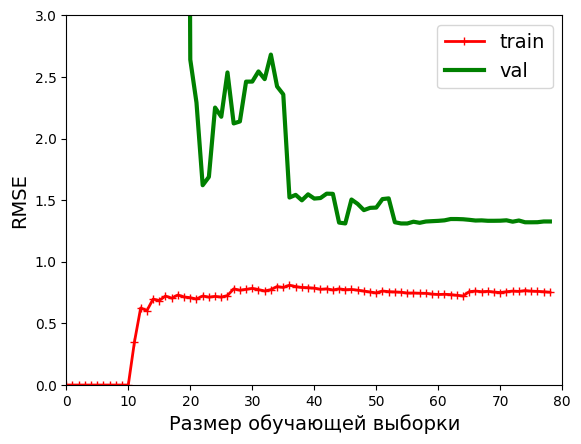

In [93]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plt.axis([0, 80, 0, 3])
plot_learning_curves(polynomial_regression, X, y)

Кривые выглядят чуть лучше предыдущих, но есть два очень важных отличия:
<ul>
    <li>Ошибка на обучающих данных гораздо ниже, чем в случае линейной регрессии;</li>
    <li>Между кривыми имеется промежуток. Это значит, что модель выполняется существенно лучше на обучающих данных, чем на проверочных данных, демонстрируя признак переобучения. Тем не менее, если вы примените намного более крупный обучающий набор, то две кривые продолжат сближаться.</li>
</ul>

$$Компромисс\ между\ смещением\ и\ дисперсией$$

Важным теоретическим результатом статистики и машинного обучения считается тот факт, что ошибка обобщения модели может быть выражена в виде суммы трёх очень разных ошибок.

<b>Смещение.</b> Эта часть ошибки обобщения связана с невероятными предположениями, такими, как допущение того, что данные являются линейными, когда на самом деле они квадратичные. Модель с высоким смещением почти наверняка недообучится на обучающих данных.

<b>Дисперсия.</b> Эта часть объясняется чрезмерной чувствительностью модели к небольшим изменениям в обучающих данных. Модель со многими степенями свободы (такая как полиноминальная модель высокой степени), вероятно, будет иметь высокую дисперсию и потому переобучаться обучающими данными.

<b>Неустранимая погрешность.</b> Эта часть появляется вследствие зашумленности самх данных. Единственный способ сократить неустранимую погрешность в ошибке предусматривает очистку данных (например, приведение в порядок источников данных, таких как неисправные датчики, или выявление и устранение выбросов).

<b>Возрастание сложности модели обычно увеличивает её дисперсию и уменьшает смещение. И наоборот, сокращение сложности модели увеличивает её смещение и уменьшает дисперсию. Вот почему это называется компромиссом.</b>

## Регуляризированные линейные модели
Хороший способ снизить переобучение заключается в том, чтобы <i>регуляризировать модель</i> (т. е. ограничить её): чем меньше степеней свободы она имеет, тем труднее её будет переобучить данными. Простой метод регуляризации полиномиальной модели предполагает сокращение количества полиномиальных степеней.

Для линейной модели регуляризация обычно достигается путём ограничения весов модели. Мы рассмотрим <i>гребневую регрессию (Ridge Regression), лассо-регрессию (Lasso Regression) и эластичную сеть (Elastic Net)</i>, которые реализую три разных способа ограничения весов.

### Гребневая регрессия
Гребневая регрессия (также называемая регуляризацией Тихонова) является регуляризированной версией линейной регрессии: к функции издержек добавляется член регуляризации (regularisation term), равный $\sum_{i=1}^n \theta_i^2$. Это заставляет алгоритм обучения не только приспосабливаться к данным, но также удерживать веса модели насколько возможно небольшими. Обратите внимание, что член регуляризации должен добавляться к функции издержек только во время обучения. После того как модель обучена, вы захотите оценить эффективность модели с использованием нерегуляризированной меры эффективности.

Гиперпараметр а управляет тем, насколько необходимо регуляризировать модель. Когда $\alpha = 0$, гребневая регрессия оказывается просто линейной регрессией. При очень большом значении а все веса становятся крайне близкими к нулю, и результатом будет ровная линия, проходящая через середину данных.

Функция издержек для гребневой регрессии выглядит следующим образом:
$$J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^n \theta^2$$

Как и в случае линейной регрессии, мы можем производить гребневую регрессию, либо вычисляя уравнение в аналитическом виде, либо выполняя градиентный спуск. Доводы за и против одинаковы.

Перед выполнением гребневой регрессии важно масштабировать данные (скажем, посредством StandardScaler), т.к. она
чувствительна к масштабу входных признаков. Это справедливо для большинства регуляризированных моделей.

In [97]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[2]])

array([[6.16530761]])

И с применением стохастического градиентного спуска:

In [99]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y)
sgd_reg.predict([[2]])

/home/agat.local/s.bulganin/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6.15648242])

### Лассо-регрессия
Регрессия методом наименьшего абсолютного сокращения и выбора (Least Absolute Shrinkage and Selection Operator (Lasso) Regression), называемая просто лассо-регрессией, представляет собой ещё одну регуляризированную версию линейной регрессии: в точности как гребневая регрессия она добавляет к функции издержек член регуляризации, но вместо одной второй квадрата нормы $l_2$ весового вектора использует норму $l_1$ весового вектора.
$$J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^n |\theta_i|$$

Для лассо-моделей используются меньшие значения $\alpha$.

Важной характеристикой лассо-регрессии является то, что она стремится полностью исключить веса наименее важных признаков (т. е. установить их в 0). Другими словами, лассо-регрессия автоматически выполняет выбор признаков и выпускает <i>разреженную</i> модель (т.е. с незначительным числом ненулевых признаков.

### Эластичная сеть
Эластичная сеть — это серединная точка между гребневой регрессией и лассо-регрессией. Член регуляризации представляет собой просто смесь членов регуляризации гребневой регрессии и лассо-регрессии, к тому же можно также управлять отношением смеси r. При r = 0 эластичная сеть эквивалент на гребневой регрессии, а при r = 1 она эквивалентна лассо-регрессии.
$$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n|\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2$$

Итак, когда вы должны применять обыкновенную линейную регрессию (т.е. без какой-либо регуляризации), гребневую регрессию, лассо-регрессию или эластичную сеть? Почти всегда предпочтительнее иметь хотя бы немного регуляризации, поэтому в целом вам следует избегать использования обыкновенной линейной регрессии. Гребневая регрессия — хороший вариант по умолчанию, но если вы полагаете, что полезными будут лишь несколько признаков, то должны отдавать предпочтение лассо-регрессии или эластичной сети, поскольку, как уже обсуждалось, они имеют тенденцию понижать веса бесполезных признаков до нуля. В общем случае эластичная сеть предпочтительнее лассо-регрессии, потому что лассо-регрессия может работать с перебоями, когда количество признаков больше числа обучающих образцов или некоторые признаки сильно связаны.

In [100]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[2]])

array([5.41958878])

## Логистическая регрессия
Некоторые алгоритмы регрессии могут применяться также и для классификации (и наоборот). <i>Логистическая регрессия</i> (также называемая <i>логит-регрессией</i> обычно используется для оценки вероятности того, что образец принадлежит к определённому классу (например, какова вероятность того, что заданное почтовое письмо является спамом?). Если оценка вероятности более 50%, тогда модель прогнозирует, что образец принадлежит к заданному классу (называемому <i>положительным классом</i> и помечаемому "1"), а иначе -- что не принадлежит (т.е. к  <i>отрицательному классу</i>, помеченному "0"). Это делает её двоичным классификатором.

### Оценивание вероятностей
Так каким образом работает логистическая регрессия? Подобно линейной регрессионной модели логистическая регрессионная модель подсчитывает взвешенную сумму входных признаков (плюс член смещения), но вместо выдачи результата напрямую, как делает линейная регрессионная модель, она выдаёт <i>логистику</i> результата.
$$\hat{p} = h_\theta(x) = \sigma(X^T\theta)$$

Логистика, обозначаемая $\sigma$, представляет собой сигмоидальную (т.е. S-образной формы) функцию, которая выдает число между 0 и 1.

После того как логистическая регрессионная модель оценила вероятность $\hat{p} = h_\theta(x)$ принадлежности образца x к положительному классу, она может легко выработать прогноз $\hat{y}$.

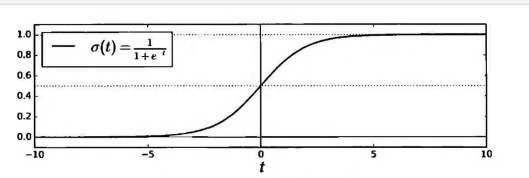

### Обучение и функция издержек
Теперь вы знаете, каким образом логистичеческая регрессионная модель оценивает вероятности и вырабатывает прогнозы. Но как её обучить? Целью обучения является установка вектора параметров $\theta$ так, чтобы модель выдавала оценки в виде высокой вероятности для положительных образцов (y=1) и низкой вероятности для отрицательных образцов (y=0). Указанная идея воплощена в функции издержек, приведенной ниже, для одиночного обучающего образца x.

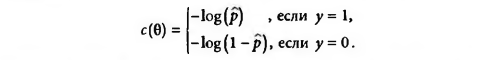

Такая функция имеет смысл, потому что $-log(t)$ растет очень медленно, когда t приближается к 0, поэтому издержки будут большими, если модель оценивает вероятность близко к 0 для положительного образца, и они также будут сверхбольшими, если модель оценивает вероятность близко к 1 для отрицательного образца. С другой стороны, $-log(t)$ близко к 0, когда t близко к 1, а потому издержки будут близки к 0, если оценка вероятности близка к 0 для отрицательного образца или близка к 1 для положительного образца, что в точности является тем, чего мы хотим.

Функция издержек на полном обучающем наборе представляет собой просто средние издержки на всех обучающих образцах. Она также может быть записана в виде одного выражения, называемого <i>логарифмической потерей (log loss)</i>.

## Упражнения

### Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов

<b>Цель</b>: В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

Обратите внимание на распределение целевой переменной.

Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :)
Критерии оценки: Максимум - 10 баллов

За качественную предобработку и визуализации - 5 баллов, за настройку и визуализацию коэффициентов моделей - еще 5 баллов. 

### Построение модели логистической регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов
<b>Цель</b>: В этом домашнем задании вы потренируетесь в настройке модели логистической регрессии, подборе коэффициента регуляризации и интерпретации результатов.
Снова про болезни, на этот раз про рак груди. Нужно научиться предсказывать, является ли клеточное образование злокачественным или нет.

1) Скачайте данные с Kaggle - https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv 

2) Как всегда - базовые статистики, визуализации (распределения, корреляции, pair-plots). В тех графиках, которые это позволяют, раскрасьте значения в зависимости от того, является опухоль злокачественной или нет.

3) Как вы помните, логистическая регрессия плохо относится к линейно-зависимым признакам, во время предобработки, уберите переменные, корреляция пирсона между которыми превышает 0.85. Разбейте данные на train-test, отложив 30% выборки для тестирования. Приведите все непрерывные переменные к одному масштабу при помощи стандартизации.

4) Постройте модель логистической регрессии "из коробки" без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней. Визуализируйте влияние коэффициентов на целевую переменную.

5) Теперь проведите настройку параметра регуляризации C на кросс-валидации (LogisticRegressionCV). Снова оцените результаты и постройте визуализацию влияния коэффициентов на целевую переменную. Сделайте интересные выводы :)

Бонусное задание - постройте также модель KNN с настройкой числа соседей на CV. У какой модели качество оказалось выше?

Критерии оценки: Максимум - 10 баллов.

За качественную предобработку и визуализации - 5 баллов, за настройку и визуализацию коэффициентов моделей - еще 5 баллов. 